<a href="https://colab.research.google.com/github/spentaur/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module3-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
from tqdm import tqdm

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [0]:
import matplotlib.pyplot as plt

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
#   time_on_site = random.uniform(10, 600)
# i'm just gunna use the abs which messes up the dist but in this use case 
#it doesn't reeeally matter
  time_on_site = abs(random.gauss(9.4*60, 3*60))
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
#   time_on_site = random.uniform(5, 300)
  time_on_site = abs(random.gauss(7.5*60, 2*60))
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
users[:10]

[User(purchased=True, time_on_site=456.7093550142004, mobile=True),
 User(purchased=True, time_on_site=644.0990546463006, mobile=True),
 User(purchased=False, time_on_site=342.1688715787346, mobile=True),
 User(purchased=True, time_on_site=498.45551776483734, mobile=True),
 User(purchased=False, time_on_site=406.56642946826247, mobile=True),
 User(purchased=True, time_on_site=606.6189588557103, mobile=True),
 User(purchased=False, time_on_site=415.16451189682135, mobile=True),
 User(purchased=True, time_on_site=551.2431036881144, mobile=False),
 User(purchased=True, time_on_site=600.5454124529907, mobile=True),
 User(purchased=False, time_on_site=465.08683485111624, mobile=True)]

In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,True,456.709355,True
1,True,644.099055,True
2,False,342.168872,True
3,True,498.455518,True
4,False,406.566429,True


In [0]:
user_data['time_on_site_mins'] = user_data['time_on_site'] / 60

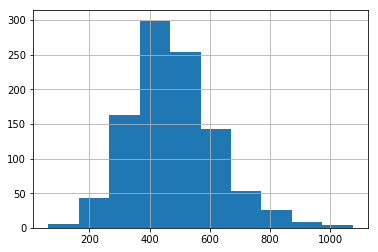

In [0]:
user_data.time_on_site.hist();

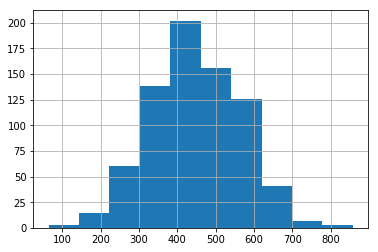

In [0]:
user_data.loc[user_data['mobile']].time_on_site.hist();

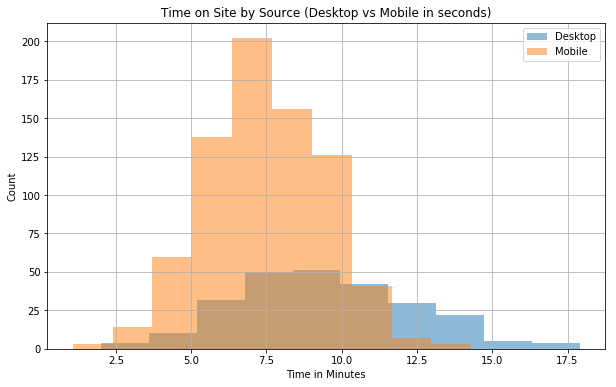

In [0]:
user_data.groupby('mobile')['time_on_site_mins'].hist(alpha=.5, figsize=(10,6));
plt.title('Time on Site by Source (Desktop vs Mobile in seconds)')
plt.ylabel('Count')
plt.xlabel('Time in Minutes')
plt.legend(['Desktop', 'Mobile'])
plt.show();

In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,63.96425275143997,120.23741601097521,122.69538285002238,123.66496208178421,149.20689890747497,151.32756908321016,167.4199985397696,172.98242763507653,173.53898243894616,173.9391039501662,179.59950849786935,184.1729681748451,186.22092363918375,187.09355994238445,187.49233728491595,198.38177778193204,205.9821378017639,206.58336851773555,216.26890019884223,216.97595975481343,219.1556880984912,222.6424677516556,223.89653081908176,224.3930729543472,227.22778644718358,227.92819529196782,230.48933251025613,230.5296126655259,233.69324359856378,236.9946774264589,237.5151961059349,237.68212269964926,237.85541417141673,238.11080427679462,240.41027428623755,244.78821789300002,248.63060992046422,252.127598971319,252.37178067988367,252.60321183636728,...,760.9752367722449,774.1235706187163,775.5592139832795,781.8804317213069,783.3142942314556,783.7986251720581,785.6071682067641,790.5634237069327,791.3543764448436,792.6229812912363,793.8090800798474,796.6159592591064,807.6321095912588,808.3403025382352,809.5354405867483,810.9998253451834,818.887353240691,819.2440180616385,821.4828756569265,827.2527553312395,836.6869795327962,838.8294221807648,840.4157505532198,843.0934218737775,844.7001102692425,855.2763464140594,858.2345379235261,874.4360639772668,878.7587852669928,883.1940731068289,883.3828238829731,903.012075013183,912.0102248536708,915.5972472404587,930.01308992328,937.5787495358536,990.5131520683608,993.9009131822476,1067.820737495157,1074.7199881414547
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,0,1,0,1,0,1,1,1,0,1,1,1,1,1,0,0,0,1,0,0,1,1,1,1,1,1,1,1,0,1,0,0,1,1,0,1,0,...,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1
True,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,1,...,1,0,1,1,1,1,1,0,0,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,1,0,1,1,1,1,1,1,0,1,1,0,1,1,0,0


In [442]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(time_bins, user_data['purchased'], normalize='columns')

purchased,False,True
time_on_site,,
"(62.953, 266.115]",0.076167,0.030354
"(266.115, 468.267]",0.511057,0.428331
"(468.267, 670.418]",0.339066,0.436762
"(670.418, 872.569]",0.063882,0.089376
"(872.569, 1074.72]",0.009828,0.015177


In [340]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(time_bins, user_data['purchased'], normalize='columns')

purchased,False,True
exercise_time,,
"(-0.3, 75.0]",0.280098,0.303541
"(75.0, 150.0]",0.282555,0.276560
"(150.0, 225.0]",0.213759,0.227656
"(225.0, 300.0]",0.223587,0.192243


In [341]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.464,0.388
True,0.536,0.612


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

In [342]:
time_bins = pd.cut(user_data['time_on_site_mins'], 5)  # 5 equal-sized bins
pd.crosstab(time_bins, [user_data['mobile'],user_data['purchased']], normalize='columns')

mobile                False               True           
purchased             False     True      False     True 
time_on_site_mins                                        
(1.049, 4.435]     0.060345  0.007463  0.082474  0.037037
(4.435, 7.804]     0.310345  0.238806  0.591065  0.483660
(7.804, 11.174]    0.422414  0.410448  0.305842  0.444444
(11.174, 14.543]   0.172414  0.276119  0.020619  0.034858
(14.543, 17.912]   0.034483  0.067164  0.000000  0.000000

In [0]:
%%time
police = pd.read_csv('il_chicago_2019_02_25.csv')

In [0]:
print(police.shape)
police.head()

In [0]:
police.isna().sum()

In [0]:
police.isna().mean().round(4) * 100

In [0]:
thresh = len(police) * .7
print(thresh)
police.dropna(thresh = thresh, axis = 1, inplace = True)

In [0]:
police.isna().mean().round(4) * 100

In [0]:
police['violation'].value_counts()

In [0]:
police['']

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

In [0]:
import numpy as np

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/spentaur/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv', index_col=0)

In [239]:
print(df.shape)
df.head()

(1200, 3)


,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


In [0]:
df.isna().sum()

age              0
weight           0
exercise_time    0
dtype: int64

In [0]:
df.dtypes

age              int64
weight           int64
exercise_time    int64
dtype: object

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
df.describe()

,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000
mean,48.396667,153.540833,134.910833
std,18.166802,35.132182,85.548895
min,18.000000,100.000000,0.000000
25%,33.000000,125.000000,65.000000
50%,48.000000,149.000000,122.000000
75%,64.000000,180.250000,206.000000
max,80.000000,246.000000,300.000000


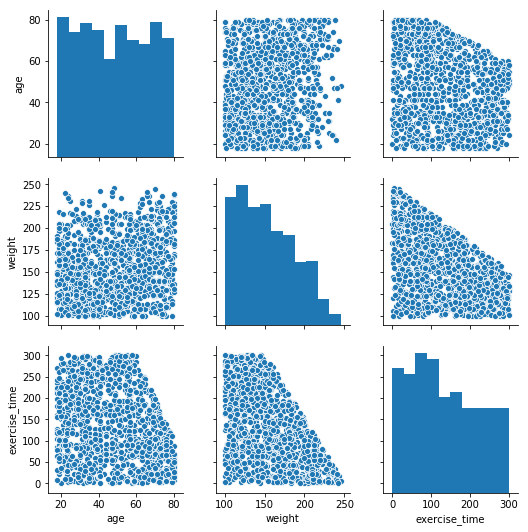

In [467]:
sns.pairplot(df);
# looks like exercise time and weight and exercise time and age are corelated possibly
# but those dist are whack yo

In [0]:
# so exercise_time increases weight decreases and maybe exercice_time stead until ~60 age then rapidly decreases
# dist are whack, so that's says something
# so is there actually a correlation between exercise time and weight or age

In [468]:
ct = pd.crosstab(weight_bin, [df['age'], df['exercise_time']], normalize="index")
ct.T

weight             (99.854, 129.2]  ...  (216.8, 246.0]
age exercise_time                   ...                
18  9                     0.000000  ...        0.000000
    31                    0.000000  ...        0.000000
    63                    0.000000  ...        0.000000
    79                    0.002667  ...        0.000000
    85                    0.000000  ...        0.000000
    104                   0.002667  ...        0.000000
    119                   0.000000  ...        0.000000
    122                   0.000000  ...        0.000000
    128                   0.000000  ...        0.000000
    156                   0.000000  ...        0.000000
    161                   0.002667  ...        0.000000
    182                   0.000000  ...        0.000000
    199                   0.002667  ...        0.000000
    213                   0.000000  ...        0.000000
    217                   0.000000  ...        0.000000
    224                   0.002667  ...        0

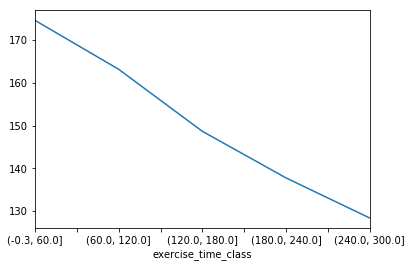

In [257]:
df.groupby('exercise_time_class')['weight'].mean().plot(kind="line")

In [0]:
crosstab = pd.crosstab(df['age_class'], df['weight'])

TypeError: ignored

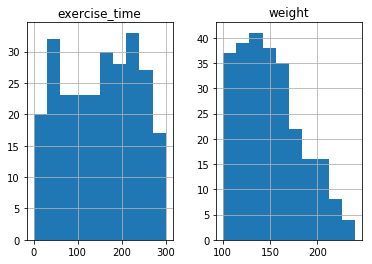

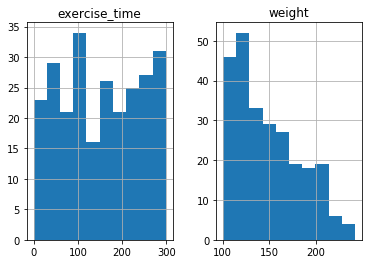

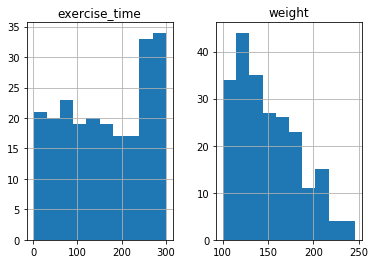

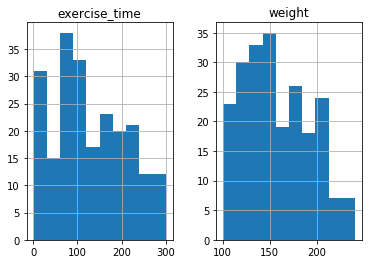

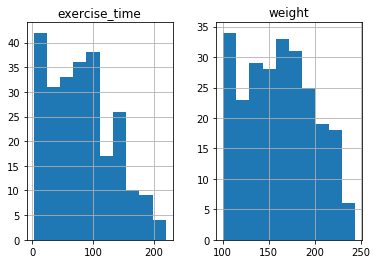

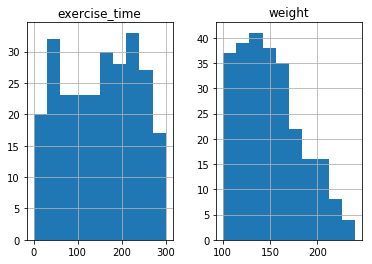

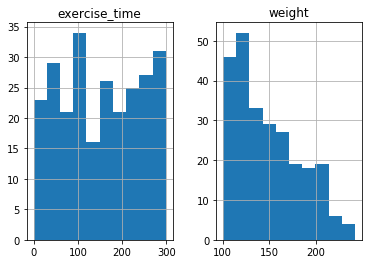

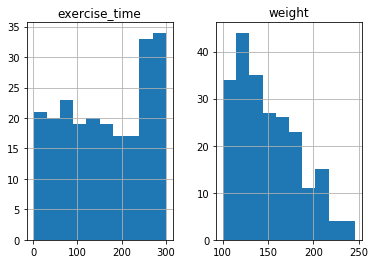

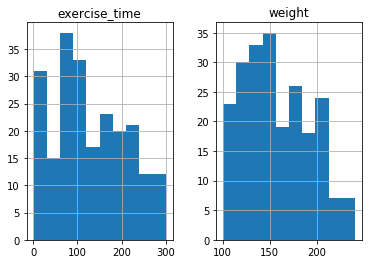

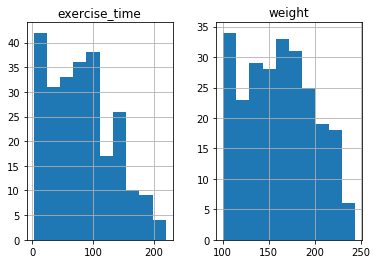

In [289]:
df.groupby('age_class')[['weight', 'exercise_time']].hist()

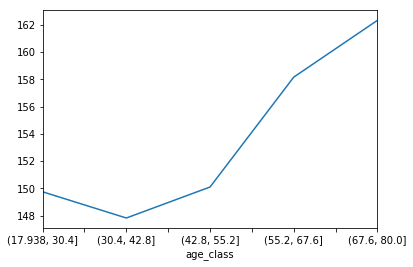

In [258]:
df.groupby('age_class')['weight'].mean().plot(kind="line")

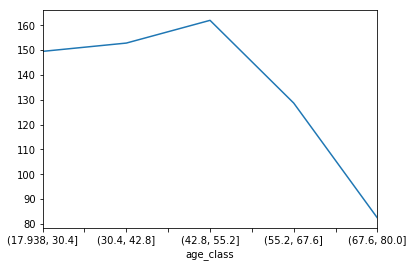

In [259]:
df.groupby('age_class')['exercise_time'].mean().plot(kind="line")

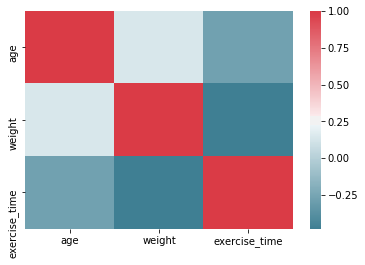

In [0]:
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))

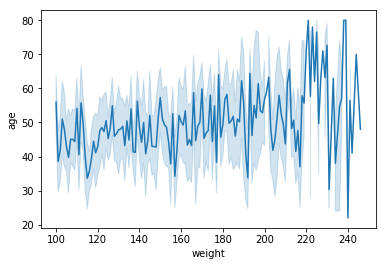

In [0]:
# plot weight by age
sns.lineplot(x="weight", y="age", data=df);
# doesn't look like anything to me

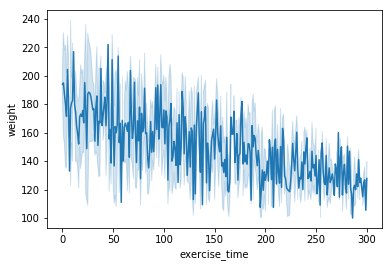

In [0]:
# plot exercise_time by weight
sns.lineplot(x="exercise_time", y="weight", data=df);

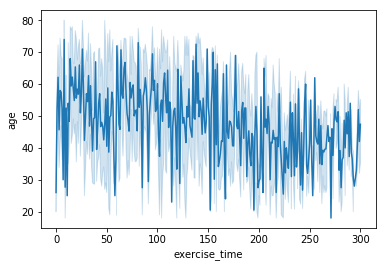

In [0]:
sns.lineplot(x="exercise_time", y="age", data=df);

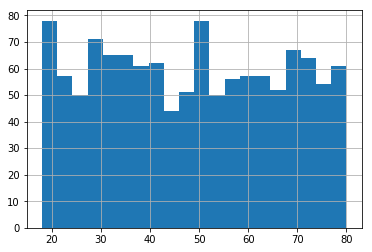

In [0]:
df['age'].hist(bins=20);

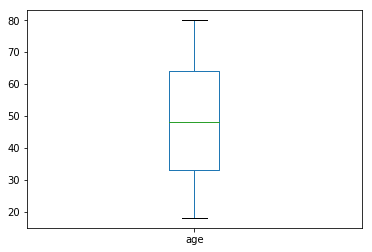

In [0]:
df['age'].plot.box();

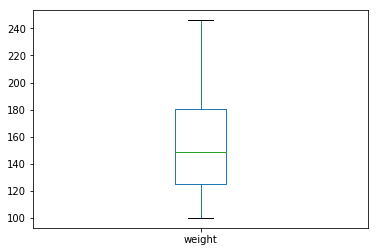

In [0]:
df['weight'].plot.box();

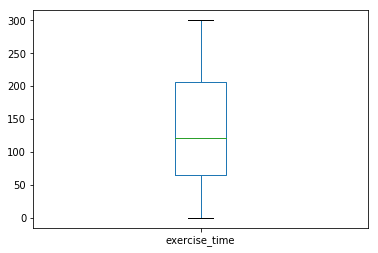

In [0]:
df['exercise_time'].plot.box();

In [0]:
exercise_bin = pd.cut(df['exercise_time'], 5)  # 5 equal-sized bins
weight_bin = pd.cut(df['weight'], 3)
age_bin = pd.cut(df['age'], 5)

In [472]:
weight_bin.head()

0     (99.854, 148.667]
1    (148.667, 197.333]
2     (99.854, 148.667]
3      (197.333, 246.0]
4     (99.854, 148.667]
Name: weight, dtype: category
Categories (3, interval[float64]): [(99.854, 148.667] < (148.667, 197.333] < (197.333, 246.0]]

In [0]:
print(df['exercise_time_class'].value_counts())
df.groupby('exercise_time_class')[['age']].mean()
# people that exercise a lot tend to be younger

(-0.3, 100.0]     505
(100.0, 200.0]    384
(200.0, 300.0]    311
Name: exercise_time_class, dtype: int64


,age
exercise_time_class,
"(-0.3, 100.0]",53.526733
"(100.0, 200.0]",47.434896
"(200.0, 300.0]",41.254019


In [0]:
print(df['weight_class'].value_counts())
df.groupby('weight_class')[['age', 'exercise_time']].mean()
# there a lot more people in this that weigh between 100 and 150

(99.854, 148.667]     598
(148.667, 197.333]    421
(197.333, 246.0]      181
Name: weight_class, dtype: int64


,age,exercise_time
weight_class,,
"(99.854, 148.667]",46.153846,169.183946
"(148.667, 197.333]",49.619952,118.893112
"(197.333, 246.0]",52.961326,58.933702


In [0]:
print(df['age_class'].value_counts())
df.groupby('age_class')[['weight', 'exercise_time']].mean()
# younger people tend to lighter

(17.938, 38.667]    426
(59.333, 80.0]      390
(38.667, 59.333]    384
Name: age_class, dtype: int64


,weight,exercise_time
age_class,,
"(17.938, 38.667]",149.225352,149.143192
"(38.667, 59.333]",150.026042,160.867188
"(59.333, 80.0]",161.715385,93.807692


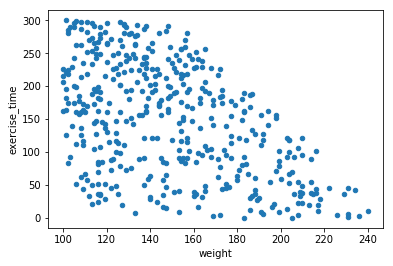

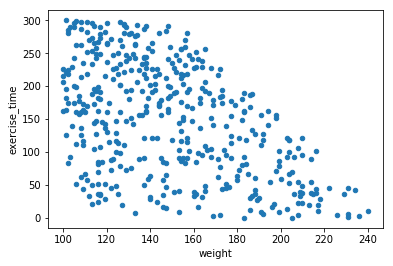

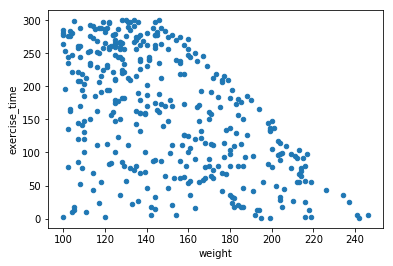

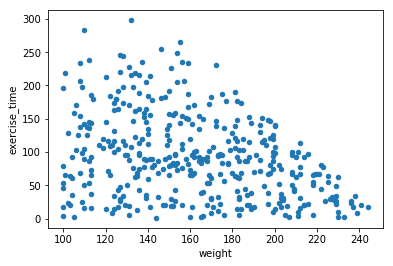

In [0]:
df.groupby('age_class').plot.scatter('weight', 'exercise_time');

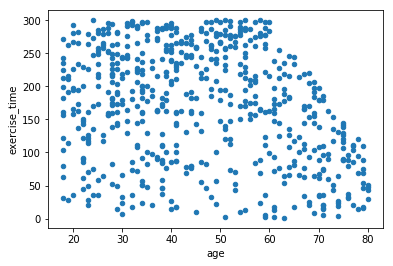

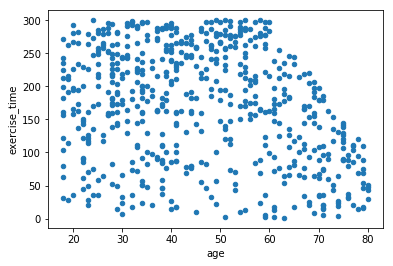

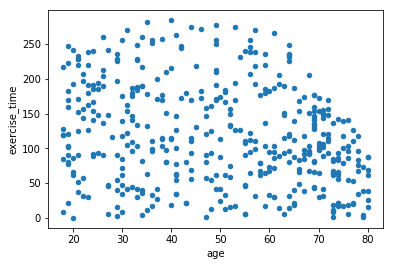

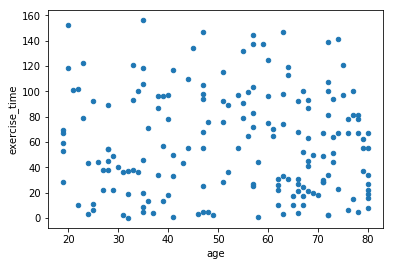

In [0]:
df.groupby('weight_class').plot.scatter('age', 'exercise_time');

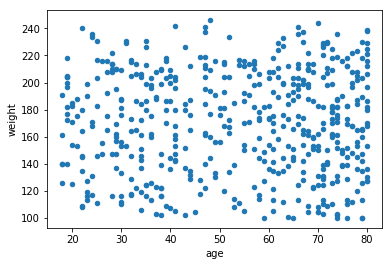

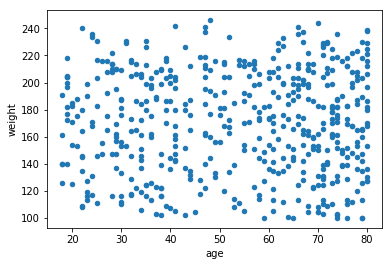

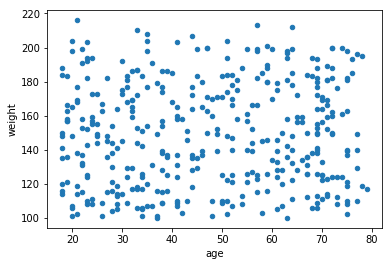

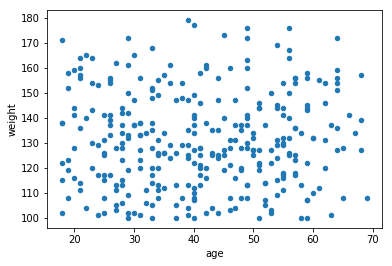

In [0]:
df.groupby('exercise_time_class').plot.scatter('age', 'weight');

In [251]:
print(df['exercise_time_class'].value_counts())
df.groupby('exercise_time_class')[['age', 'weight']].size()

(60.0, 120.0]     316
(-0.3, 60.0]      278
(120.0, 180.0]    223
(180.0, 240.0]    192
(240.0, 300.0]    191
Name: exercise_time_class, dtype: int64


exercise_time_class
(-0.3, 60.0]      278
(60.0, 120.0]     316
(120.0, 180.0]    223
(180.0, 240.0]    192
(240.0, 300.0]    191
dtype: int64

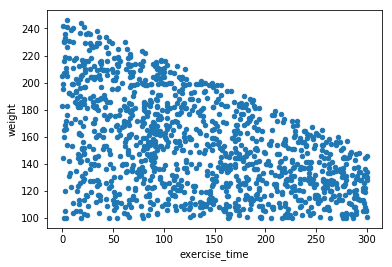

In [0]:
df.plot.scatter('exercise_time', 'weight');

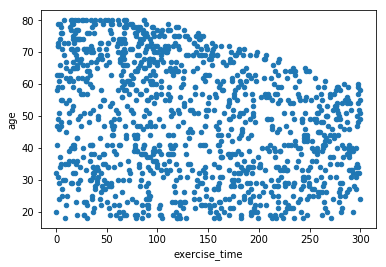

In [0]:
df.plot.scatter('exercise_time', 'age');

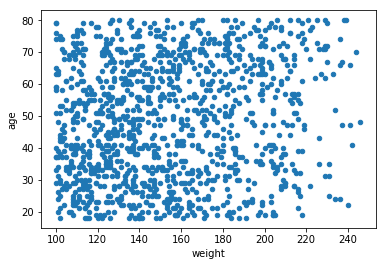

In [0]:
df.plot.scatter('weight', 'age');

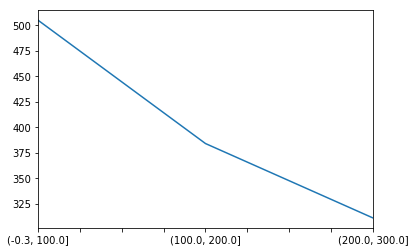

In [0]:
df['exercise_time_class'].value_counts().plot.line()
# what this is saying is that the group of people that there's lot of people in this 

In [398]:
df[df['weight'] == 100].sort_values(by="exercise_time_class").head(50)

,age,weight,exercise_time,exercise_time_class,weight_class,age_class
197,74,100,4,"(-0.3, 60.0]","(99.854, 129.2]","(67.6, 80.0]"
339,65,100,18,"(-0.3, 60.0]","(99.854, 129.2]","(55.2, 67.6]"
398,79,100,54,"(-0.3, 60.0]","(99.854, 129.2]","(67.6, 80.0]"
911,79,100,46,"(-0.3, 60.0]","(99.854, 129.2]","(67.6, 80.0]"
1096,59,100,2,"(-0.3, 60.0]","(99.854, 129.2]","(55.2, 67.6]"
639,76,100,79,"(60.0, 120.0]","(99.854, 129.2]","(67.6, 80.0]"
288,37,100,163,"(120.0, 180.0]","(99.854, 129.2]","(30.4, 42.8]"
473,33,100,206,"(180.0, 240.0]","(99.854, 129.2]","(30.4, 42.8]"
544,29,100,226,"(180.0, 240.0]","(99.854, 129.2]","(17.938, 30.4]"
628,37,100,216,"(180.0, 240.0]","(99.854, 129.2]","(30.4, 42.8]"


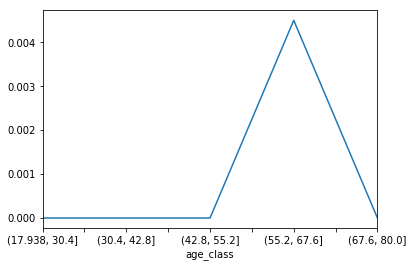

In [421]:
ct = pd.crosstab(df['age_class'], [df['weight'], df['exercise_time']], normalize="index").T

In [0]:
# third var is the number of people in light weight class?
df['weight_class'] = pd.cut(df['weight'], 3)
df['age_class'] = pd.cut(df['age'], 3)
df['exercise_time_class'] = pd.cut(df['exercise_time'], 3)

In [478]:
df.head()

,age,weight,exercise_time,weight_class
0,44,118,192,"(99.854, 148.667]"
1,41,161,35,"(148.667, 197.333]"
2,46,128,220,"(99.854, 148.667]"
3,39,216,57,"(197.333, 246.0]"
4,28,116,182,"(99.854, 148.667]"


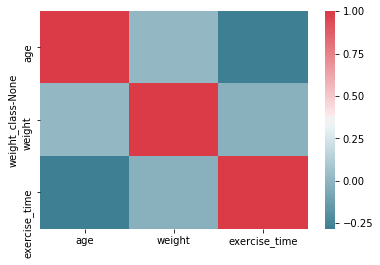

In [529]:
# this aint right lol
corr1 = df.groupby('weight_class').corr().iloc[:3]
corr2 = df.groupby('weight_class').corr().iloc[3:6]
corr3 = df.groupby('weight_class').corr().iloc[6:9]
sns.heatmap(corr1, xticklabels=corr1.columns, yticklabels=corr1.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))

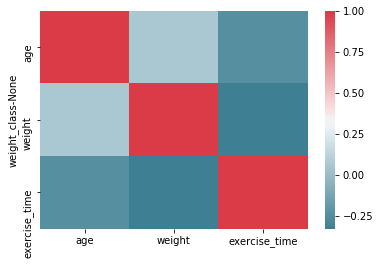

In [530]:
sns.heatmap(corr2, xticklabels=corr2.columns, yticklabels=corr2.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))

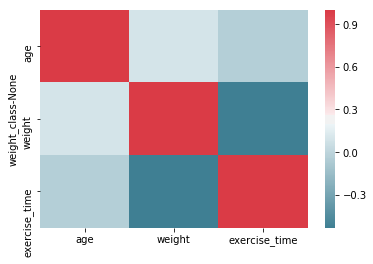

In [532]:
sns.heatmap(corr3, xticklabels=corr3.columns, yticklabels=corr3.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))

                    age    weight  exercise_time
age            1.000000  0.144168      -0.273818
weight         0.144168  1.000000      -0.478021
exercise_time -0.273818 -0.478021       1.000000


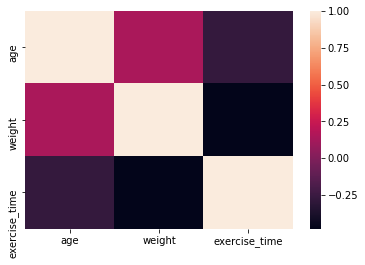

In [544]:
corr = df.corr()
print(corr)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

In [486]:
df['weight_class'].value_counts()

(99.854, 148.667]     598
(148.667, 197.333]    421
(197.333, 246.0]      181
Name: weight_class, dtype: int64

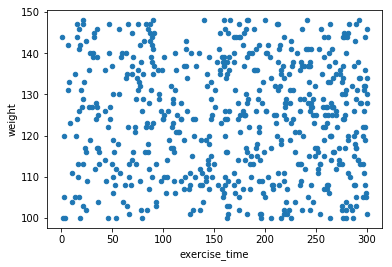

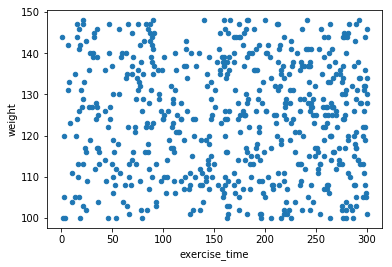

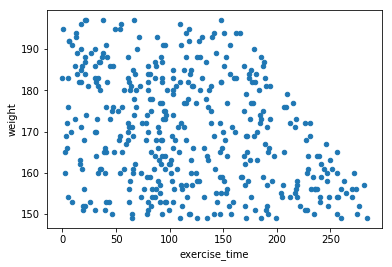

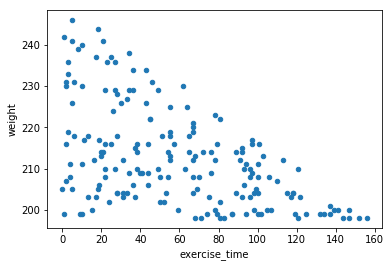

In [612]:
df.groupby('weight_class').plot.scatter('exercise_time', 'weight');

               exercise_time    weight
exercise_time       1.000000 -0.212996
weight             -0.212996  1.000000
               exercise_time    weight
exercise_time       1.000000 -0.478021
weight             -0.478021  1.000000
(900, 6)


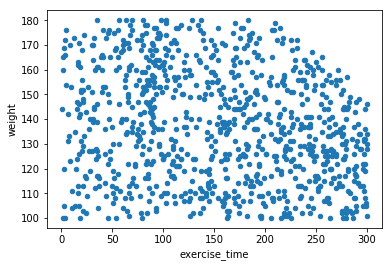

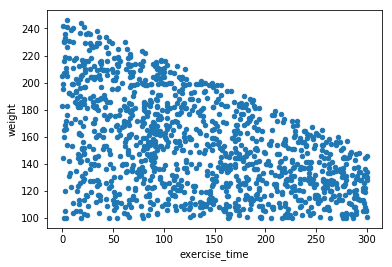

In [613]:
corr1 = df[(df['weight'] <= 180)][['exercise_time', 'weight']].corr()
corr = df[['exercise_time', 'weight']].corr()
print(corr1)
print(corr)
print(df[(df['weight'] <= 180)].shape)


df[(df['weight'] <= 180)].plot.scatter('exercise_time', 'weight');
df.plot.scatter('exercise_time', 'weight');

                    age  exercise_time
age            1.000000      -0.504498
exercise_time -0.504498       1.000000
                    age  exercise_time
age            1.000000      -0.273818
exercise_time -0.273818       1.000000
(336, 6)
[[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa387804748>


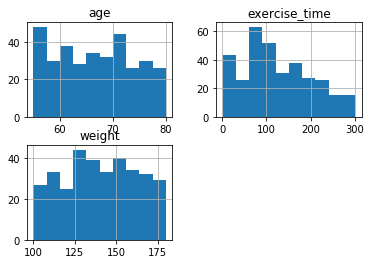

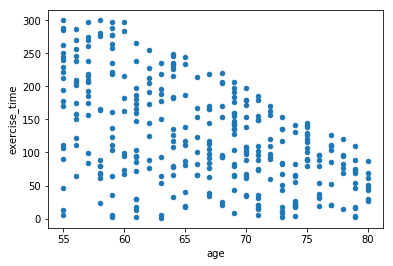

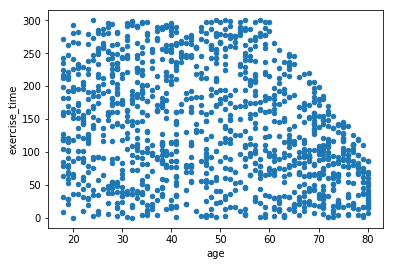

In [617]:
corr1 = df[(df['age'] >= 55) & (df['weight'] <= 180)][['age', 'exercise_time']].corr()
corr = df[['age', 'exercise_time']].corr()
print(corr1)
print(corr)
print(df[(df['age'] >= 55) & (df['weight'] <= 180)].shape)
print(df[(df['age'] >= 55) & (df['weight'] <= 180)].hist());

df[(df['age'] >= 55) & (df['weight'] <= 180)].plot.scatter('age', 'exercise_time');
df.plot.scatter('age', 'exercise_time');

                 weight  exercise_time
weight         1.000000      -0.507418
exercise_time -0.507418       1.000000
                 weight  exercise_time
weight         1.000000      -0.478021
exercise_time -0.478021       1.000000
(469, 6)


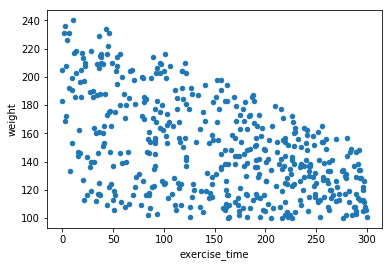

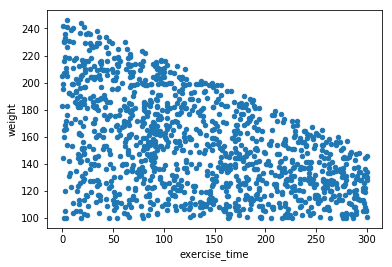

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?



---



1. good ol int64, so pythonically i suppose discrete, but practically they are continous i believe
2. exercise and weight appear to be pretty strongly correlated, and age and exercise have a correlation after 60. 
3. the exercise and age relationship is real, but the exercise and weight relationship is spurious becuase of the distribution, it skews right a lot, so when we look at the pearson correlation coefficient when we group by age we can see that the relationship doesn't start until weight is in the upper quartile.


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)